In [1]:
import os

import bayes_net_utils as bn
import pandas as pd

pd.options.display.width = None

# Historic predictions from chosen 'operational' models

Forecasts were originally going to be based on a GBN including several weather-related nodes (mean seasonal wind speed and seasonal precipitation sum). However, the results of cross validation of the Bayesian Network and different versions of the network, and a comparison of different models for the hindcast period, lead to the following choices for models to use in operational forecasting:

- TP: GBN (no met included anyway in BN)
- chla: Naive seasonal forecast
- colour: GBN, no met (stats were marginally better when including weather, but unlikely to still be the case when using Seas5 met forecasts)
- cyano: GBN, no met

Here, produce forecasts for the historic period using this model choice

# User options

In [2]:
# User options

# Source of met data (if any) used to train the GBN?
# From: 'metno', 'nomet', 'era5'
met_source = 'metno'

# Set start and end years (of data used to fit the network and evidence data used when making predictions)
# Available years vary by met source type (e.g. met.no data only goes to 2018, ERA5 to 2019, nomet currently to 2020)
st_yr = 1981
end_yr = 2018

# Standard deviation of the box cox transformed cyanobacteria observations
# For use when back-transforming cyanobacteria predictions (with bias-adjustment)
sigma_obs_cyano = 1.29  # Mean for period 1980-2018 or 2019

# Fitted bnlearn objects
rfile_fpath = "../Data/RData/Vansjo_fitted_GaussianBN_%s_%s-%s.rds" % (met_source, st_yr, end_yr)

# Pre-calculated standard deviations (from fitting of GBN in NB 02)
sd_fpath = "../Data/FittedNetworkDiagnostics/GBN_%s_%s-%s_stdevs.csv" % (met_source, st_yr, end_yr)

# The 'evidence' csv (data that will be used to drive the predictions)
ev_path = r'../Data/DataForPrediction/Historic/%s/DataForPrediction_GBN_%s_%s-%s.csv' % (met_source, met_source, st_yr, end_yr)

# Filepath to observations, for calculating seasonally naive forecast
obs_fpath = '../Data/DataMatrices/Seasonal_BN_obs/seasonal_obs_GBN_1980-2019.csv'

# Outfolder to save predictions in
out_folder = r'../Data/Predictions/Historic'
out_fname = 'Prediction_operational_%s_%s-%s.csv' % (met_source, st_yr, end_yr)

# Seasonal naive forecast

Simplest possible model: target season = previous season

In [3]:
# Read in observations
seasonal_obs_df = pd.read_csv(obs_fpath, index_col=0)

# Predict
naive_sim_df_wide = seasonal_obs_df.shift(+1).loc[1981:]

# Reformat to long format
naive_sim_df_wide = naive_sim_df_wide.reset_index()
sim_naive = pd.melt(
    naive_sim_df_wide,
    id_vars=["year"],
    value_vars=["TP", "chla", "cyano", "colour"],
    var_name="node",
    value_name="expected_value",
)

# Add predicted class
# Dictionary of thresholds to use. N.B. Also defined in bayes_net_utils.R (as boundaries_list)
boundaries_dict = {
    "TP": 29.5,  # Middle of 'Moderate' class
    "chla": 20.0,  # M-P boundary. WFD boundaries: [10.5, 20.0]. Only 6 observed points under 10.5 so merge G & M
    "colour": 48.0,  # 66th percentile (i.e. upper tercile). No management implications
    "cyano": 1.0,  # M-P boundary is 2.0, but there were only 2 values in this class. Plenty above 2 tho
}

sim_naive["WFD_class"] = sim_naive[["node", "expected_value"]].apply(
    lambda x: bn.discretize([boundaries_dict[x.node]], x.expected_value), axis=1
)

sim_naive.tail()

,year,node,expected_value,WFD_class
151,2015,colour,41.863636,0.0
152,2016,colour,52.833333,1.0
153,2017,colour,52.000000,1.0
154,2018,colour,42.000000,0.0
155,2019,colour,36.333333,0.0


# GBN predictions

In [4]:
def bn_predict_multipleyears_operational(rfile_fpath, ev_df, sigma_obs_cyano):
    """
    Loop over rows in evidence dataframe and make predictions for each row (year),
    and concatenate results into a single df

    The same as bn_predict_multipleyears, but calls the function bayes_net_predict_operational,
    rather than bayes_net_predict. This makes almost no difference to the results, but it does
    make a tiny difference, so worth doing just for consistency across prediction notebooks.

    Inputs:
    - filepath to fitted BN object
    - dataframe containing evidence to use when making predictions
      (column names must match BN node names)
    - sigma_obs_cyano: standard deviation of box cox transformed cyanobacteria observations,
      for use when back-transforming GBN cyanobacteria predictions

    Returns: dataframe of predictions for each year in ev_df, including expected value,
             probability of being above or below WFD-relevant thresholds
    """
    df_list = []
    for idx, row in ev_df.iterrows():
        # Run Bayesian network in R
        df = bn.bayes_net_predict_operational(rfile_fpath,
                                              float(row['year']),
                                              float(row['chla_prevSummer']),
                                              float(row['colour_prevSummer']),
                                              float(row['TP_prevSummer']),
                                              sigma_obs_cyano
                                              )
        df_list.append(df)

    # Merge results from all years
    df = pd.concat(df_list, sort=True)
    df.reset_index(drop=True, inplace=True)

    # Re-order cols
    df = df[['year', 'node', 'threshold', 'prob_below_threshold',
             'prob_above_threshold', 'expected_value', 'WFD_class']]

    return df

# Operational forecast

Merge the two

In [5]:
# Read in evidence
ev_df = pd.read_csv(ev_path)

# Predict with GBN
df = bn_predict_multipleyears_operational(rfile_fpath, ev_df, sigma_obs_cyano)

# Replace chl-a predictions with the naive seasonal forecast
sim_naive_chla = sim_naive.loc[sim_naive['node'] == 'chla']
df_operational = df.drop(df.loc[df['node'] == 'chla'].index)

df_operational = sim_naive_chla.set_index(['year',
                                           'node']).append(df_operational.set_index(['year','node']),
                                                           sort=False)
df_operational = df_operational.reset_index()
df_operational.loc[df_operational['node'] == 'chla', 'threshold'] = boundaries_dict['chla']

# Save to csv
out_path = os.path.join(out_folder, out_fname)
df_operational.to_csv(out_path, index=False)

df_operational

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down
/tmp/ipykernel_5291/1897600808.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_operational = sim_naive_chla.set_index(['year',


,year,node,expected_value,WFD_class,threshold,prob_below_threshold,prob_above_threshold
0,1981,chla,16.08013,0.0,20.0,NaN,NaN
1,1982,chla,8.33125,0.0,20.0,NaN,NaN
2,1983,chla,5.97500,0.0,20.0,NaN,NaN
3,1984,chla,6.05000,0.0,20.0,NaN,NaN
4,1985,chla,11.09000,0.0,20.0,NaN,NaN
...,...,...,...,...,...,...,...
148,2017,cyano,0.52300,0.0,1.0,0.89,0.11
149,2017,TP,22.20000,0.0,29.5,0.97,0.03
150,2018,colour,41.00000,0.0,48.0,0.77,0.23
151,2018,cyano,0.80200,0.0,1.0,0.79,0.21


# Time series for operational model

This was copied and pasted from the hindcast stats and plots notebook. Needs integrating into this notebook. Doesn't run now.

KeyError: "['sim_era5_av'] not in index"

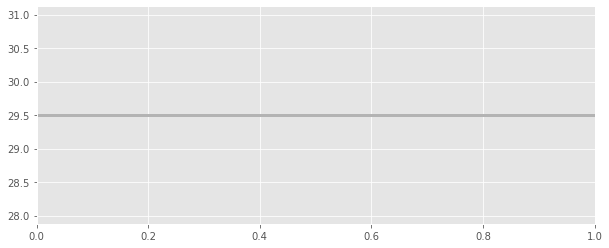

In [20]:
ylabel_dict = {'TP': 'TP (mg/l)',
               'chla': 'Chl-a (mg/l)',
               'colour': 'Colour (mg Pt/l)',
               'cyano': 'Cyanobacterial biovolume (mm$^3$/l)'}

# Loop over vars
for idx, var in enumerate(var_list):

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)

    # Add WFD boundary
    ax.axhline(y=boundaries_dict[var], color='0.7', lw=3)

    # Extract data

    # Forecasted
    if var != 'chla':
        forecasted = df_cont.loc[df_cont['node'] == var, ['sim_era5_av', 'year']]
    else:
        forecasted = df_cont.loc[df_cont['node'] == var, ['sim_naive', 'year']]
    forecasted = forecasted.set_index('year')

    # Observed
    obs = df_cont.loc[df_cont['node'] == var, ['obs', 'year']]
    obs = obs.set_index('year')

    # Plot forecast
    ax.plot(forecasted.index,
            forecasted.values,
            color='r',
            lw=1,
            label='Forecast')

    # Plot observations
    ax.plot(obs.index,
            obs.values,
            color='k',
            lw=1,
            label='Observed')

    # Tidy
    ax.set_ylabel(ylabel_dict[var])
    ax.set_xlim(xmin=1980, xmax=2020)
    ax.legend()

    plt.savefig(os.path.join(out_folder, 'Timeseries_gof', 'timeseries_operationalModel_%s.png' %var), dpi=150)